<a href="https://colab.research.google.com/github/bmf87/ml-ds-projects/blob/main/ds552/wk3_assign3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 552 - Generative AI
* Assignment 3: Variational Autoencoders (VAE)
* Datasets: CIFAR-10 and EuroSat
* Author: Brett Favro

VAEs are a foundational generative model that use probabilistic modeling with variational inference, KL Divergence, and Evidence Lower Bound (ELBO) that balances reconstruction accuracy with a regularization term.  The VAE encoder produces smooth embeddings that can be useful for mutliple downstream tasks, e.g. classification, anomaly detection, data augmentation or synthetic data generation.

&nbsp;

**Objectives:**

1. Compare the following VAE architectures and the generated images:
    * Fully Connected Layers - consists of linear layers that flatten 3D output (height, width, channels) into a 1D vector. Each neuron connects to the previous layer, creating dense, global interactions.
    * Convolutional Layers - each neuron connects to small region of the previous layer via sliding filters/kernels, enabling sparse local feature detection. Convolutional layers extract spatial features very well.
2. Compare VAE model interpolated images
    * ConvVAE preserves spatial structure and creates a valid object that exists semantically between the original two
    * FCVAE creates what looks like a crossfade. The images just fade out. The model has not learned. It essential outputs the average color, which typically looks like a blur.
3. Train the VAEs on a higher-fidelity dataset. Use a more complex dataset that is 64x64 pixels with finer detail and more accurate shapes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import os

## VAE Theory Questions:

1. Why is the KL Divergence term important in the loss function?

> The KL Divergent term turns a variational autoencoder into a generative model. Without KL Divergence or with reconstruction loss only, the VAE would just be a compressor useful for data compression ($\beta_0 = 0$) and produce the perfect reconstruction of training data.

> KL Divergence regularizes the latent space, ensuring it is smooth and continuous, while minimizing differences between the learned distribution and a Gaussian distribution. It forces the encoder's posterior to be close to a simple prior p(z), pulling each q(z|x) towards the prior so an aggregate latent distribution resembles p(z).

  > Pure reconstruction alone would use all latent dimensions and memorize details, ending up with model overfitting.

  > Without KL Divergence you have a regular autoencoder that cannot reliably generate new samples by sampling from z. This mean no generation/generalization ability.


2. How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

  > In a VAE encoder you want to learn a normal (Gaussian) distribution. Autograd (differentiation engine) cannot compute gradients through naive black-box sampling. *How would z change if mu is changed by 0.001?* Autograd cannot tell and define
  $\frac{\partial z}{\partial \mu}$
  
            z = torch.normal(mu, std)
  
  > Autograd must have a "deterministic" function. So you put randomness into another variable called eps, which does not depend on the paramters mu and std. Gradients can now flow because z is a deterministic differentiable function of mu and std.
  
            eps = torch.randn_like(std)
            z = mu + eps * std

  > This introduces randomness and the network sees stochastic behavior in each pass. You end up with a deterministic function of parameters with external noise input.

  > **[Summary]:**
  Reparameterization does NOT change what distribution you sample from; reparameterization only changes how you express the sample so that backpropagation can flow through stochastic layers.


3. Why does a VAE use a probabilistic latent space instead of a fixed latent space?

  > In a fixed latent space, the encoder would return a fixed z per image, leaving no meaningful place to sample from. The decoder would know about fixed points from the training data; decode(z) would provide no guarantee the returned point corresponded to anything related or meaningful in latent space. These results would often be random noise and blurry images.

  > With a probabilistic latent space, the encoder outputs μ, σ². The VAE can sample from prior z ~ N(0,1) and decode(z) to generate a novel image. ***Why?*** The KL term has forced training encodings to cluster around standard normal priors. The decoder learns to map entire continuous regions around N(0,1) and generate/create realistic images from this structure and not just return random fixed points that may have no relationship.


4. What role does KL Divergence play in ensuring a smooth latent space?


  > KL Divergence prevents fragmented, disconnected encodings and enforces a regular structure.


  > * KL(D(q(z|x) || N(0,I))) forces the following:
    1. Means μ ≈ 0 (centered around origin)
    2. Variances σ² ≈ 1 (reasonably spread out)
    3. No extreme outliers (posteriors stay "normal-looking")

  > **Net Result**: All encodings occupy a continuous "Gaussian blob" region

  > **[Summary]:**
  > 1. μ ≈ 0 centers the encodings. Images encode to nearby regions. Short interpolation paths stay meaningful.
  2. σ² ≈ 1 similar images have continuous transitions.
  3. Balanced KL -> encoder uses input but stays near prior, keeping a nice smooth, continuous structure.



## Define Models

### VAE Arch: Fully Connected Layers
* Suitable for tabular data, embeddings, or input already in 1D vector
* Updated to include ***input_shape*** variable to handle differnt dataset sizes (CIFAR-10 32x32 vs CelebA 64x64). ***input_dim*** defines Linear layers in the encoder and decoder based in the dataset size.

In [ ]:
class FCVAE(nn.Module):
    def __init__(self, latent_dim=64, input_shape=(3, 32, 32)):
        super(FCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape = input_shape
        # px height x px width x 3 (RGB channels)=> large vector
        self.input_dim = input_shape[0] * input_shape[1] * input_shape[2]

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.input_dim),
            nn.Sigmoid() # Pixel values in [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder(z)
        x = x.view(-1, *self.input_shape)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


### VAE Arch: Convolutional Layers
* Best suited for input with spatial structures like images or spectograms
* Convolutions exploit locality and share weights, giving better sample quality and parameter efficiency
* Architecture updates included:
  * Inclusion of ***input_shape*** variable to manage different dataset sizes (CIFAR-10 32x32 vs CelebA 64x64). ***flatten_dim*** resizes in the encoder output layer to adjust the decoder's input layer based on the dataset.
  * Refactored from Upsample+Conv to PixelShuffle or Sub-Pixel Convolution. It is considered more parameter efficient and preserves finer details. Image clarity did increase after this change.

In [ ]:
class ConvVAE(nn.Module):
      def __init__(self, latent_dim=64, input_shape=(3, 32, 32), sharpen_factor=1.0):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape = input_shape
        self.sharpen_factor = sharpen_factor

        # Encoder - Using LeakyReLU for better gradient flow
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 32x16x16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64x8x8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128x4x4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.feature_map_shape = self._get_feature_map_shape()
        self.flatten_dim = self.feature_map_shape[0] * self.feature_map_shape[1] * self.feature_map_shape[2]

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_var = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder - Using Upsample + Conv to avoid checkerboard artifacts
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
            # 4x4 -> 8x8 (if starting from 4x4, but we handle dynamics)
            # Actually PixelShuffle doubles resolution.
            # Layer 1: Upsample by 2.
            nn.Conv2d(128, 64 * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # Layer 2: Upsample by 2.
            nn.Conv2d(64, 32 * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Layer 3: Upsample by 2 to Final Resolution.
            nn.Conv2d(32, 3 * 4, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.Sigmoid()
        )

      def _get_feature_map_shape(self):
        dummy_input = torch.zeros(1, *self.input_shape)
        with torch.no_grad():
          x = self.encoder_conv(dummy_input)
        return x.shape[1:]

      def encode(self, x):
        x = self.encoder_conv(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

      def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

      def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, *self.feature_map_shape)
        x = self.decoder_conv(x)

        # Post-decoder sharpening
        if self.sharpen_factor > 1.0:
            x = TF.adjust_sharpness(x, sharpness_factor=self.sharpen_factor)
        return x

      def forward(self, x):
        if x.shape[2:] != self.input_shape[1:]:
            raise ValueError(f"Input shape {x.shape[2:]} does not match model initialization shape {self.input_shape[1:]} \
                             Initialize with input_shape={x.shape[1:]} for this dataset.")
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


### VGGPerceptualLoss - Trying to break the blur barrier
* Generative models trained with MSE or L1 tend to average all possible modes near the mean to minimize variance causing blur.
* VGGPerceptualLoss - maps an image to high-dimensional feature space using a pre-trained feature extractor (VGG-16). Loss is then calculated in the feature semantic space and not the pixel space.
  * Uses VGG16 trained on ImageNet
  * Summing loss across VGG layers forces the VAE to match texture and overall structure

In [ ]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        # Load VGG16 pretrained on ImageNet
        # Use features up to certain layers to capture texture/structure
        blocks.append(models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(models.vgg16(pretrained=True).features[16:23].eval())

        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False

        self.blocks = nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        # Input should be [0, 1] range. VGG expects normalized Input.
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)

        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std

        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)

        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)

        return loss


### Reusable Functions

In [ ]:
BATCH_SIZE = 128
data_dir = './data'

def detect_device():
    if torch.cuda.is_available():
      print("Found <<Nvidia GPU>>")
      print(f"CUDA Version: {torch.version.cuda}")
      print(f"Number of GPUs: {torch.cuda.device_count()}")
      print(f"Current GPU Name: {torch.cuda.get_device_name(0)}")
      DEVICE = torch.device('cuda')
    else:
      DEVICE = torch.device('cpu')
    return DEVICE

def load_cifar10(shuffle_test=False):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle_test)
    return train_loader, test_loader

# Download quota issues=>move on!
def load_celebA(shuffle_test=False):
    image_size = 64
    transform = transforms.Compose([
      transforms.Resize((image_size, image_size)),
      transforms.ToTensor(),
    ])
    train_dataset = datasets.CelebA(root=data_dir, split='train', target_type='attr', download=True, transform=transform)
    test_dataset = datasets.CelebA(root=data_dir, split='test', target_type='attr', download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle_test)
    return train_loader, test_loader

# CIFAR-10 equiv at 64x64x3: contains 10 classes
def load_eurosat(shuffle_test=False):
    transform = transforms.Compose([
      transforms.ToTensor(), # convert TIFF -> [0,1] tensors
    ])
    full_dataset = datasets.EuroSAT(root=data_dir, download=True, transform=transform)
    #img, _ = full_dataset[0]
    #print(f"First image shape: {img.shape}")             # Expect torch.Size([3, 64, 64])
    #print(f"Range: [{img.min():.3f}, {img.max():.3f}]")  # [-3ish, 3ish] after norm
    #print(f"Tensor dtype: {img.dtype}")
    #print(f"Min: {img.min():.4f}, Max: {img.max():.4f}") # Expect [0.0, 1.0]

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    trainset, testset = random_split(full_dataset, [train_size, test_size])
    # Wrap in DataLoaders to reuse code
    train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=shuffle_test)
    return train_loader, test_loader

def loss_function(recon_x, x, mu, log_var, perceptual_loss_fn=None, beta=1.0):
    # Standard VAE Loss: Batch Mean, Pixel Sum
    batch_size = x.size(0)
    # MSE is better for color images with Gaussian assumption
    #MSE_loss = nn.MSELoss(reduction='sum')
    #MSE = MSE_loss(recon_x, x)

    # 1. Reconstruction Loss (L1)
    loss_fn = nn.L1Loss(reduction='sum')
    reconstruction_loss = loss_fn(recon_x, x) / batch_size

    # 2. Perceptual Loss (VGG)
    p_loss = 0.0
    if perceptual_loss_fn is not None:
        p_loss = perceptual_loss_fn(recon_x, x)

        # Want p_loss to be significant, not overwhelming
        # Weight of ~10.0 usually brings it to comparable magnitude with pixel sum
        reconstruction_loss += (0.1 * p_loss * 12288) # Scale up to match ~pixel sum magnitude

        # Since our L1 is ~200. VGG standard L1 is ~3-4.
        # Weight of 10-50 might be needed. Start with 20.0
        reconstruction_loss += (20.0 * p_loss)

    # 3. KL Divergence
    kld_element = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
    KLD = torch.sum(kld_element) / batch_size

    return reconstruction_loss + (beta * KLD)

def train(model, train_loader, optimizer, epochs, model_name, perceptual_loss_fn=None):
    model.to(DEVICE)
    if perceptual_loss_fn:
        perceptual_loss_fn.to(DEVICE)

    model.train()
    print(f"Training {model_name}...")

    for epoch in range(epochs):
        #beta = min(1.0, epoch / 5.0)
        beta = min(0.50, epoch * 0.05)
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(DEVICE)
            optimizer.zero_grad()

            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, data, mu, log_var, perceptual_loss_fn, beta)

            loss.backward()
            total_loss += loss.item()

            # Gradient Clipping: if gradients small->scale to prevent explosion!
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            # loss.item() is "Average per Image". To get "Total Batch Loss", multiply by batch size.
            total_loss += loss.item() * data.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Beta: {beta:.2f}')

    save_dir = './models'
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}.pt")

    torch.save(model.state_dict(), model_path)
    print(f"Saved {model_name}.pt")

def evaluate(model, test_loader, model_name):
    model.eval()
    #total_mse = 0
    total_loss = 0
    #mse_loss = nn.MSELoss(reduction='sum')
    # switched from MSE to L1Loss
    loss_fn = nn.L1Loss(reduction='sum')
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(DEVICE)
            recon, _, _ = model(data)
            #total_mse += mse_loss(recon, data).item()
            total_loss += loss_fn(recon, data).item()

    #avg_mse = total_mse / len(test_loader.dataset)
    avg_loss = total_loss / len(test_loader.dataset)
    #print(f"{model_name} Test MSE: {avg_mse:.4f}")
    print(f"{model_name} Test L1 Loss: {avg_loss:.4f}")
    #return avg_mse
    return avg_loss

def visualize_comparison(conv_vae, fc_vae, test_loader):
    # set to inference mode
    conv_vae.eval()
    fc_vae.eval()

    # Get batch of data
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images[:8].to(DEVICE) # Grab 8 images

    with torch.no_grad():
        recon_conv, _, _ = conv_vae(images)
        recon_fc, _, _ = fc_vae(images)

        # New random generation
        z = torch.randn(8, LATENT_DIM).to(DEVICE)
        gen_conv = conv_vae.decode(z)
        gen_fc = fc_vae.decode(z)

    images = images.cpu()
    recon_conv = recon_conv.cpu()
    recon_fc = recon_fc.cpu()
    gen_conv = gen_conv.cpu()
    gen_fc = gen_fc.cpu()

    # Plotting
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))

    # Row 1: Original Images
    for i in range(8):
        axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Original", loc='left')

    # Row 2: ConvVAE Reconstruction
    for i in range(8):
        axes[1, i].imshow(np.transpose(recon_conv[i], (1, 2, 0)))
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("ConvVAE Recon", loc='left')

    # Row 3: FCVAE Reconstruction
    for i in range(8):
        axes[2, i].imshow(np.transpose(recon_fc[i], (1, 2, 0)))
        axes[2, i].axis('off')
        if i == 0: axes[2, i].set_title("FCVAE Recon", loc='left')

    # Row 4: Generate Images (Conv vs FC) - show images from both
    # Left 4: Conv, Right 4: FC

    for i in range(8):
        if i < 4:
            axes[3, i].imshow(np.transpose(gen_conv[i], (1, 2, 0)))
            axes[3, i].set_title("ConvVAE Gen" if i==0 else "")
        else:
            axes[3, i].imshow(np.transpose(gen_fc[i-4], (1, 2, 0))) # Use first 4 from FC batch
            axes[3, i].set_title("FCVAE Gen" if i==4 else "")
        axes[3, i].axis('off')

    plt.tight_layout()
    save_dir = './results'
    os.makedirs(save_dir, exist_ok=True)
    fig_path = os.path.join(save_dir, "vae_comparison.png")
    plt.savefig(fig_path)
    print("Saved vae_comparison.png")

## CIFAR-10: Train & Eval VAE Models

**[Model Results]:**


Convolutional layers learn local pattern and reuse them. Fully connected layers ignore 2D locality since you flatten the data. Data flattening is performed in the first line of the encoder of the Fully Connected architecture (FCVAE). A Convolutional VAE can model 32x32x3 (like CIFAR-10) with fewer parameters than the FCVAE. This reduces the potential for overfitting and allows for better model optimization.

&nbsp;

On both image reconstruction and generation, convolutions can reconstruct sharper local structures. The FC model must unflatten and "guess" spatial layout from a very dense vector. This is sub-optimal for image data and is better suited for non-image, tabular data. A good use case may be creating tabular synthetic data.

&nbsp;

The Convolutional layered model (ConvVAE) outperformed the FC layered model (FCVAE).
* ConvVAE: L1 Loss on test data was: ~218.00
  * Indicates a fairly low pixel deviation rate:  218/128 (batch size) = 1.70. 1.70/(32x32x3) = 0.00055 per pixel
  * Blurry images made me investigate better optimizations
* ConvVAE: L1 Loss on test data after training using Perceptual Loss: ~224.00
* FCVAE: L1 Loss was: ~356.00

**ConvVAE** results show a model that:
1. Has learned to reconstruct CIFAR-10 quite well.
2. The beta ramp-up reveals the VAE trade-off between reconstruction fidelity and latent regularization.
3. Training results showed loss at ~2000 with Perceptual Loss. This is due to VGGPerceptualLoss scaling by 20. Perceptual Loss was contributing about 1800 to the total score;VGG was therefore driving ~90% of the optimization but did not make much difference in reconstructions and generations.



**FCVAE** results show a model that:
1. Struggles to model the 32x32x3 spatial structure of the CIFAR-10 dataset from flattened 3072D vectors. Epoch 1 has loss of 541 before any regularization.
2. When KL annealing starts, the model improves but loss consistently remains 25-30% higher than ConvVAE.
3. It's interesting that between Epochs 6-10, with the beta term increasing and passing 0.20, the model continues to show loss improvement. The ConvVAE was increasing between 6-10. This could potentially indicate the FCVAE has begun overfitting to the training data.

Found <<Nvidia GPU>>
CUDA Version: 12.6
Number of GPUs: 1
Current GPU Name: NVIDIA A100-SXM4-80GB
Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 243MB/s]


Training ConvVAE...
Epoch 1/10, Loss: 379.5214, Beta: 0.00
Epoch 2/10, Loss: 268.2734, Beta: 0.05
Epoch 3/10, Loss: 254.6755, Beta: 0.10
Epoch 4/10, Loss: 249.8283, Beta: 0.15
Epoch 5/10, Loss: 250.5413, Beta: 0.20
Epoch 6/10, Loss: 252.8134, Beta: 0.25
Epoch 7/10, Loss: 256.4504, Beta: 0.30
Epoch 8/10, Loss: 260.0478, Beta: 0.35
Epoch 9/10, Loss: 263.7648, Beta: 0.40
Epoch 10/10, Loss: 267.8252, Beta: 0.45
Saved ConvVAE.pt
ConvVAE Test L1 Loss: 217.0219
Training FCVAE...
Epoch 1/10, Loss: 542.5832, Beta: 0.00
Epoch 2/10, Loss: 459.4951, Beta: 0.05
Epoch 3/10, Loss: 433.1220, Beta: 0.10
Epoch 4/10, Loss: 417.3230, Beta: 0.15
Epoch 5/10, Loss: 403.0172, Beta: 0.20
Epoch 6/10, Loss: 398.3693, Beta: 0.25
Epoch 7/10, Loss: 398.6631, Beta: 0.30
Epoch 8/10, Loss: 391.2414, Beta: 0.35
Epoch 9/10, Loss: 387.0659, Beta: 0.40
Epoch 10/10, Loss: 383.5932, Beta: 0.45
Saved FCVAE.pt
FCVAE Test L1 Loss: 354.1183
Saved vae_comparison.png


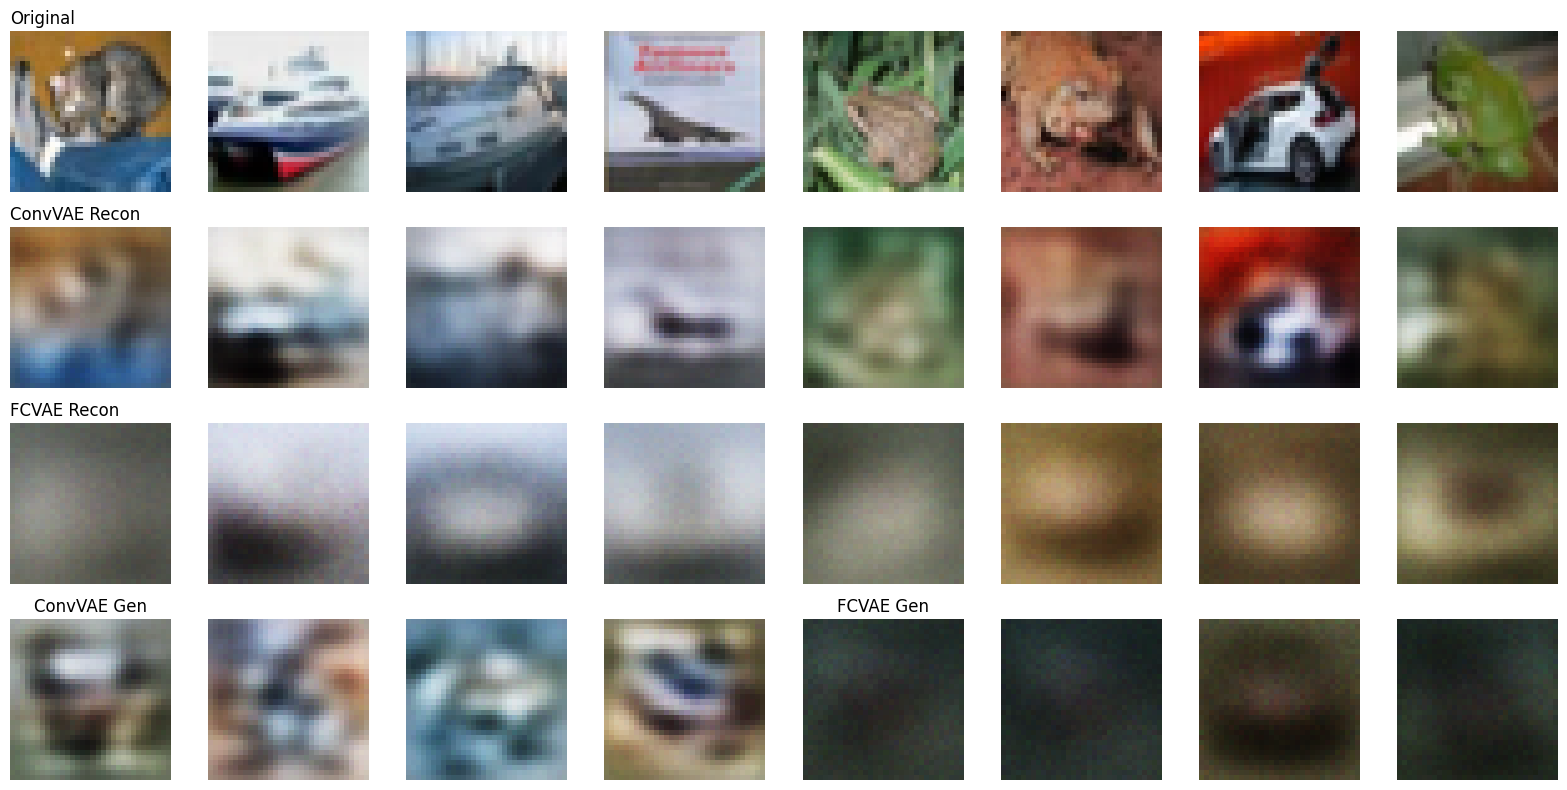

In [ ]:
# Configuration
BATCH_SIZE = 128
#LR = 1e-3
LR = 1e-4
EPOCHS = 10 # increased for KL annealing
LATENT_DIM = 64
CIFAR10_INPUT_SHAPE = (3, 32, 32)

# Check & Run on GPU
DEVICE = detect_device()
print(f"Using device: {DEVICE}")
# data: 32x32x3
train_loader, test_loader = load_cifar10()


# Initialize Perceptual Loss
# resize=True => VGG expects 224x224
#perceptual_avg = VGGPerceptualLoss(resize=True).to(DEVICE)

# Train ConvVAE
conv_vae = ConvVAE(latent_dim=LATENT_DIM, input_shape=CIFAR10_INPUT_SHAPE, sharpen_factor=1.8)
optimizer_conv = optim.Adam(conv_vae.parameters(), lr=LR)
#train(conv_vae, train_loader, optimizer_conv, EPOCHS, "ConvVAE", perceptual_loss_fn=perceptual_avg)
train(conv_vae, train_loader, optimizer_conv, EPOCHS, "ConvVAE")
evaluate(conv_vae, test_loader, "ConvVAE")

# Train FCVAE
fc_vae = FCVAE(latent_dim=LATENT_DIM, input_shape=CIFAR10_INPUT_SHAPE)
optimizer_fc = optim.Adam(fc_vae.parameters(), lr=LR)
train(fc_vae, train_loader, optimizer_fc, EPOCHS, "FCVAE")
evaluate(fc_vae, test_loader, "FCVAE")

# Compare
visualize_comparison(conv_vae, fc_vae, test_loader)

## Image Interpolation - Blending Two Images:
Interpolation creates a smooth transition between two data points by moving through the latent space.

Process:

1. Pass two images through the encoder and get their compressed, latent vectors
2. Calculate intermediate vectors on straight line between them (linear interpolation)
3. Decoder generates an image from these new vectors

### Interpolation Functions

In [ ]:
def interpolate(model, img1, img2, steps=10):
    model.eval() # inference mode
    with torch.no_grad():
        # mu's in latent space - summarize each img
        mu1, logvar1 = model.encode(img1.unsqueeze(0))
        mu2, logvar2 = model.encode(img2.unsqueeze(0))

        # Linear interpolation
        alphas = torch.linspace(0, 1, steps).to(DEVICE)
        interpolated_images = []

        for alpha in alphas:
            mu_interp = (1 - alpha) * mu1 + alpha * mu2
            logvar_interp = (1 - alpha) * logvar1 + alpha * logvar2
            # Sample using reparameterization trick
            z = model.reparameterize(mu_interp, logvar_interp)
            recon = model.decode(z)
            interpolated_images.append(recon.squeeze(0).cpu())

        return interpolated_images

def visualize_interpolation(conv_vae, fc_vae, test_loader):
    # Two random images
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    img1, img2 = images[0].to(DEVICE), images[1].to(DEVICE)

    # Interpolate
    steps = 10
    conv_interp = interpolate(conv_vae, img1, img2, steps)
    fc_interp = interpolate(fc_vae, img1, img2, steps)

    # Plotting
    fig, axes = plt.subplots(2, steps, figsize=(20, 5))

    for i in range(steps):
        # ConvVAE
        axes[0, i].imshow(np.transpose(conv_interp[i], (1, 2, 0)))
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("ConvVAE Interpolation", loc='left')

        # FCVAE
        axes[1, i].imshow(np.transpose(fc_interp[i], (1, 2, 0)))
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("FCVAE Interpolation", loc='left')

    plt.tight_layout()
    save_dir = './results'
    os.makedirs(save_dir, exist_ok=True)
    fig_path = os.path.join(save_dir, "vae_interpolation.png")
    plt.savefig(fig_path)
    print("Saved vae_interpolation.png")

### Compare Interpolated Images
* Prerequisites to run:
  1. Train & Eval VAE Models section has already run
  2. Persisted PyTorch models (*.pt) exist under /models dir

&nbsp;

**[Interpolation Results]:**
Intermediate images show that the:
* FCVAE - the FC layered model has not learned that pixels are neighbors, only that latent vector X<sub>1</sub> produces them one place, while latent vector X<sub>2</sub> produces them somewhere else. The output is a blurry image with the average color of the two originals.
* ConvVAE - the Convolutional layered model preserved spatial structure and learns features and understands the geometry in the images. The model creates a valid object that is semantically between X<sub>1</sub> and X<sub>2</sub>.

Found <<Nvidia GPU>>
CUDA Version: 12.6
Number of GPUs: 1
Current GPU Name: NVIDIA A100-SXM4-80GB
Using device: cuda
Loaded ConvVAE.pt
Loaded FCVAE.pt
Saved vae_interpolation.png


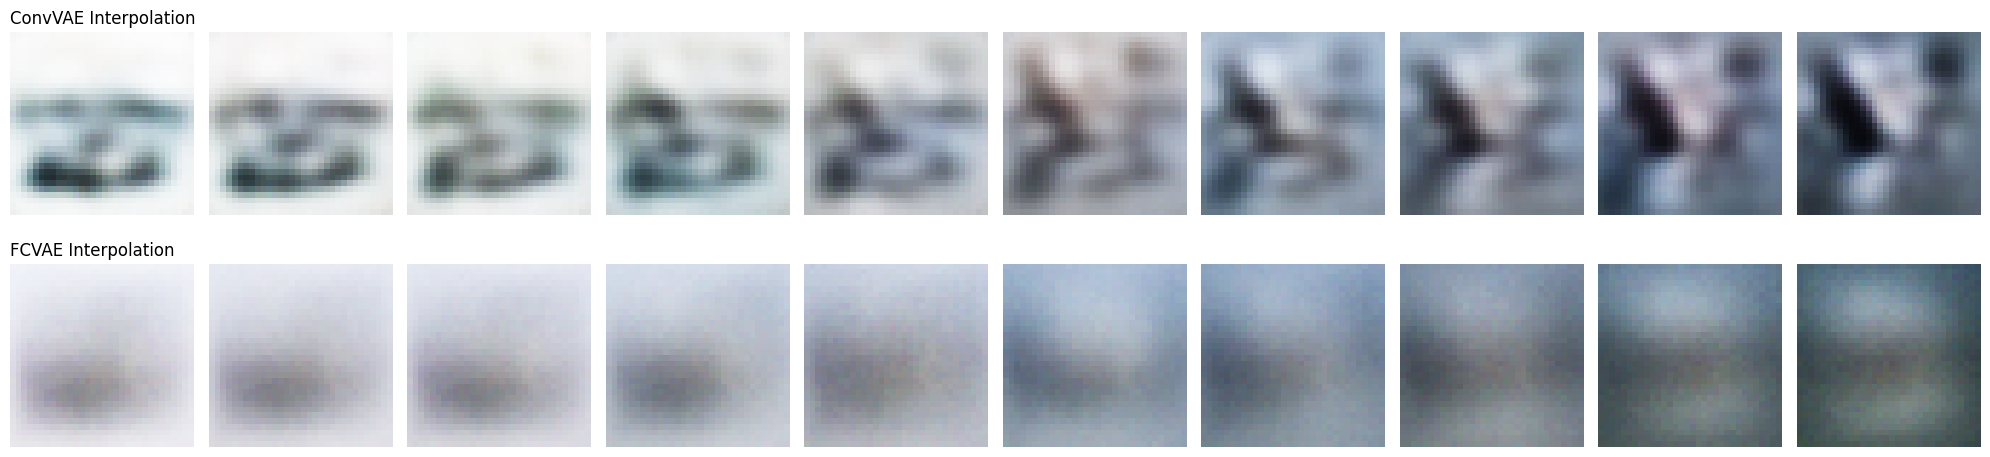

In [ ]:
# Configuration
LATENT_DIM = 64
CIFAR10_INPUT_SHAPE = (3, 32, 32)

# Check & Run on GPU
DEVICE = detect_device()
print(f"Using device: {DEVICE}")

train_loader, test_loader = load_cifar10(shuffle_test=True)

# Load Models
conv_vae = ConvVAE(latent_dim=LATENT_DIM, input_shape=CIFAR10_INPUT_SHAPE).to(DEVICE)
# ConvVAE
try:
  conv_vae.load_state_dict(torch.load('./models/ConvVAE.pt', map_location=DEVICE))
  print("Loaded ConvVAE.pt")
except FileNotFoundError:
  print("ConvVAE.pt not found!")


fc_vae = FCVAE(latent_dim=LATENT_DIM, input_shape=CIFAR10_INPUT_SHAPE).to(DEVICE)
# FCVAE
try:
  fc_vae.load_state_dict(torch.load('./models/FCVAE.pt', map_location=DEVICE))
  print("Loaded FCVAE.pt")
except FileNotFoundError:
  print("FCVAE.pt not found!")

visualize_interpolation(conv_vae, fc_vae, test_loader)

## EuroSat: Train & Eval Models
* Training on [EuroSat](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset) dataset - images are 64x64 pixels collected from the Sentinel-2 satellite
* Training *should* be conducted on at least A100 GPU or better
* Changed learning rate to 1e-4
* Removed normalization at the data set level. It was causing Sigmoid output saturation at 0.0 and unresolvable gradient errors (exploding gradients).

&nbsp;

**[Model Results]**:

Very similar to results observed on the CIFAR-10 dataset, both image reconstruction and generation were better with convolutions. The FC model must unflatten and "guess" spatial layout from a super dense vector. The regenerations and generations by the FCVAE model are just outputs of the images average color.
* The ConvVAE model is certainly better, but loss (~470 on test) is still much higher on the EuroSat dataset than CIFAR-10. As such, overall output is subpar.

Found <<Nvidia GPU>>
CUDA Version: 12.6
Number of GPUs: 1
Current GPU Name: NVIDIA A100-SXM4-80GB
Using device: cuda


100%|██████████| 94.3M/94.3M [00:01<00:00, 87.6MB/s]


Training ConvVAEx64...
Epoch 1/10, Loss: 1100.9689, Beta: 0.00
Epoch 2/10, Loss: 666.7080, Beta: 0.05
Epoch 3/10, Loss: 595.0002, Beta: 0.10
Epoch 4/10, Loss: 568.8101, Beta: 0.15
Epoch 5/10, Loss: 557.0219, Beta: 0.20
Epoch 6/10, Loss: 551.6876, Beta: 0.25
Epoch 7/10, Loss: 542.7726, Beta: 0.30
Epoch 8/10, Loss: 535.3536, Beta: 0.35
Epoch 9/10, Loss: 529.5385, Beta: 0.40
Epoch 10/10, Loss: 532.3117, Beta: 0.45
Saved ConvVAEx64.pt
ConvVAEx64 Test L1 Loss: 474.9846
Training FCVAEx64...
Epoch 1/10, Loss: 1259.0988, Beta: 0.00
Epoch 2/10, Loss: 975.2662, Beta: 0.05
Epoch 3/10, Loss: 893.5006, Beta: 0.10
Epoch 4/10, Loss: 819.8388, Beta: 0.15
Epoch 5/10, Loss: 793.1929, Beta: 0.20
Epoch 6/10, Loss: 785.4581, Beta: 0.25
Epoch 7/10, Loss: 782.6257, Beta: 0.30
Epoch 8/10, Loss: 779.4732, Beta: 0.35
Epoch 9/10, Loss: 775.4327, Beta: 0.40
Epoch 10/10, Loss: 773.1626, Beta: 0.45
Saved FCVAEx64.pt
FCVAEx64 Test L1 Loss: 735.1949
Saved vae_comparison.png


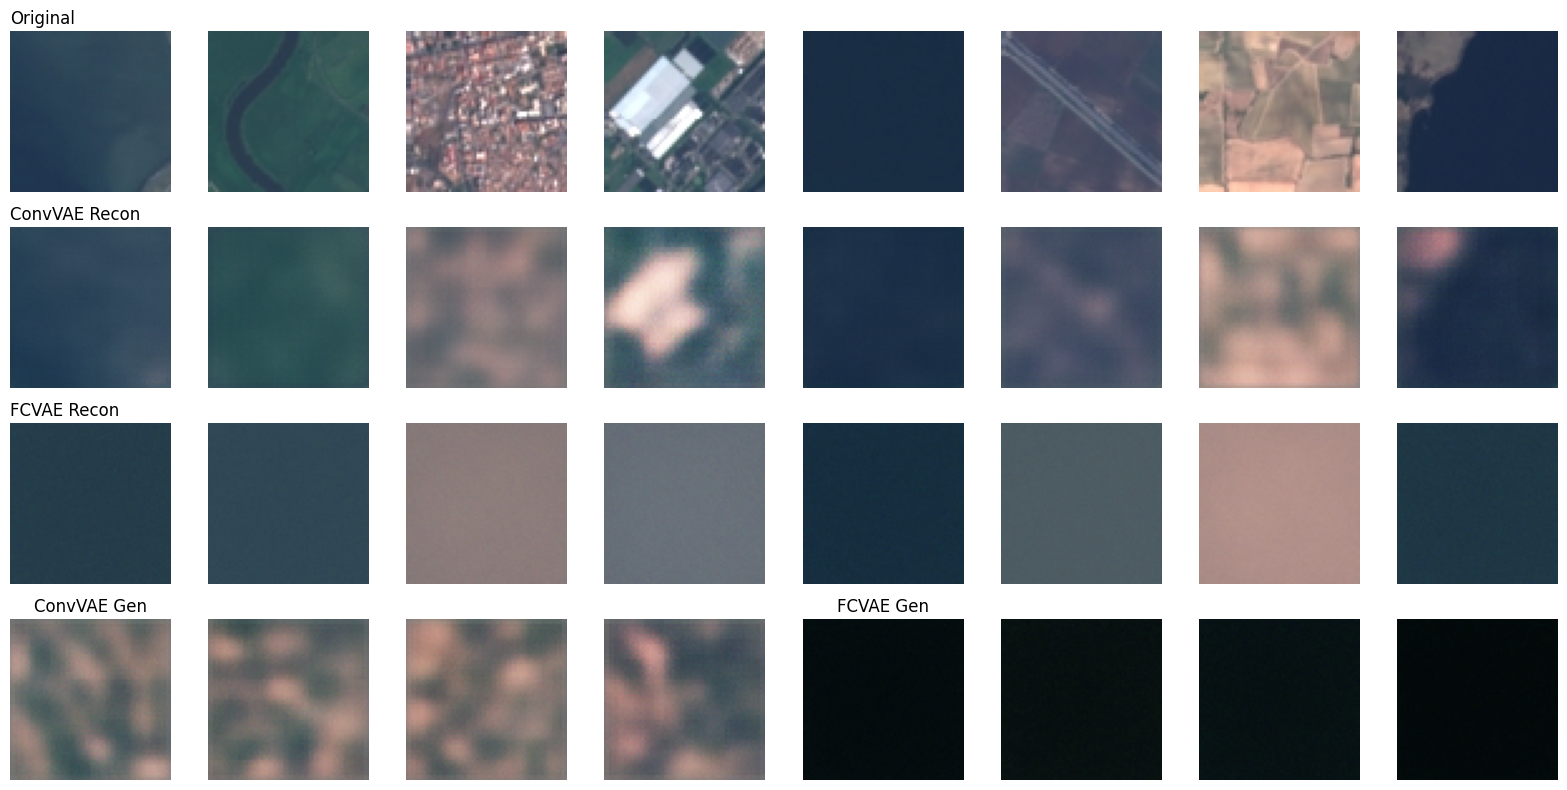

In [ ]:
# Configuration
BATCH_SIZE = 128
#LR = 1e-3 # exploding gradients w/FCVAE
LR = 1e-4 # slower training
EPOCHS = 10 # increased for KL annealing
LATENT_DIM = 64
EUROSAT_INPUT_SHAPE = (3, 64, 64)

# Check & Run on GPU
DEVICE = detect_device()
print(f"Using device: {DEVICE}")

# data: 64x64x3
train_loader, test_loader = load_eurosat()

# Train ConvVAE
conv_vae = ConvVAE(latent_dim=LATENT_DIM, input_shape=EUROSAT_INPUT_SHAPE, sharpen_factor=1.8)
optimizer_conv = optim.Adam(conv_vae.parameters(), lr=LR)
train(conv_vae, train_loader, optimizer_conv, EPOCHS, "ConvVAEx64")
evaluate(conv_vae, test_loader, "ConvVAEx64")

# Train FCVAE
fc_vae = FCVAE(latent_dim=LATENT_DIM, input_shape=EUROSAT_INPUT_SHAPE)
optimizer_fc = optim.Adam(fc_vae.parameters(), lr=LR)
train(fc_vae, train_loader, optimizer_fc, EPOCHS, "FCVAEx64")
evaluate(fc_vae, test_loader, "FCVAEx64")

# Compare
visualize_comparison(conv_vae, fc_vae, test_loader)

### Revised Interpolation Functions
* Added revised interpolation functions for:
  * Spherical Linear Interpolation (SLERP). SLERP is better suited for high-dimensional vectors. It produces better morphs between images of different classes
  * Random Walk goes anywhere. This really stress tests the latent space smoothness.
    * If it produce realistic images => Good VAE
    * If it produce garbage images immediately => Bad VAE
* Added logic to calculate skikit-image metrics. Each step of the interpolation was compared to both image1 and image2.
  * PSNR - measure of image quality as a ratio between max possible signal power and corrupting noise power expressed in decibels (DB). Higher values indicate better pixel-level fidelity.
    * Benchmarks:
      * Good: 30+ dB
      * Acceptable: 25-30 dB
      * Poor: <25 dB
  * SSIM - assesses perceived quality by comparing luminance, contrast and structural similarity between images. Values range from [-1, 1]. 1 = identical images.

In [ ]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import numpy as np

def tensor_to_np(img_tensor):
    """
    img_tensor: (C,H,W) on any device, in [0,1] or [0,255]
    returns: (H,W,C) uint8 for imshow
    """
    img = img_tensor.detach().cpu().clamp(0, 1)  # assume [0,1]
    img = (img * 255).byte()
    img = img.permute(1, 2, 0).numpy()
    #print(f"After permute(1,2,0): {img.shape}")  # Should be [64,64,3]
    return img

def compute_metrics(ref_img, imgs):
    """
    ref_img: (C,H,W) tensor
    imgs: list of (C,H,W) tensors
    returns: list of (psnr, ssim)
    """
    ref_np = tensor_to_np(ref_img)
    scores = []
    for t in imgs:
        x_np = tensor_to_np(t)
        psnr = peak_signal_noise_ratio(ref_np, x_np, data_range=255)
        ssim = structural_similarity(ref_np, x_np, channel_axis=-1, data_range=255)
        scores.append((psnr, ssim))
    return scores

def slerp(val, low, high):
    """
    Spherical Linear Interpolation
    val: float between 0 and 1
    low: starting vector
    high: ending vector
    """
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)

    omega = torch.acos(torch.clamp((low_norm*high_norm).sum(1, keepdim=True), -1, 1))
    so = torch.sin(omega)

    # Avoid division by zero
    if so.item() == 0:
        return (1.0-val) * low + val * high

    return torch.sin((1.0-val)*omega) / so * low + torch.sin(val*omega) / so * high

# SLERP: more geometrically correct interpolation for high-dimensional vectors
def interpolate_slerp(model, img1, img2, steps=10, device='cpu'):
    model.eval()
    with torch.no_grad():
        mu1, _ = model.encode(img1.unsqueeze(0))
        mu2, _ = model.encode(img2.unsqueeze(0))

        interpolated_images = []

        for alpha in np.linspace(0, 1, steps):
            # SLERP Interpolation
            z = slerp(alpha, mu1, mu2)
            recon = model.decode(z)
            interpolated_images.append(recon.squeeze(0).cpu())

        return interpolated_images

def interpolate_random_walk(model, img_start, steps=10, step_size=0.5, device='cpu'):
    """
    Starts at img_start and takes random steps into latent space
    """
    model.eval()
    with torch.no_grad():
        current_z, _ = model.encode(img_start.unsqueeze(0))

        interpolated_images = []

        for _ in range(steps):
            recon = model.decode(current_z)
            interpolated_images.append(recon.squeeze(0).cpu())

            # Take random step / Generate random normalized vector
            direction = torch.randn_like(current_z)
            direction = direction / torch.norm(direction)

            current_z = current_z + (direction * step_size)

        return interpolated_images

def viz_interpolation(model, test_loader, title="VAE"):
    # Get two random images
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    img1, img2 = images[0].to(DEVICE), images[1].to(DEVICE)
    steps = 10
    img_seq = ([tensor_to_np(img1)] + [tensor_to_np(img2)]) * 5

    # 1. Linear Interpolation (Standard)
    linear_imgs = interpolate(model, img1, img2, steps)

    # 2. SLERP Morphing (Spherical)
    slerp_imgs = interpolate_slerp(model, img1, img2, steps)

    # 3. Random Exploration (Starting from Image 1)
    random_imgs = interpolate_random_walk(model, img1, steps, step_size=0.3)

    # ---- Compute metrics w.r.t. img1 ----
    linear_scores1 = compute_metrics(img1, linear_imgs)
    linear_scores2 = compute_metrics(img2, linear_imgs)
    slerp_scores1  = compute_metrics(img1, slerp_imgs)
    slerp_scores2  = compute_metrics(img2, slerp_imgs)
    random_scores1 = compute_metrics(img1, random_imgs)
    random_scores2 = compute_metrics(img2, random_imgs)

    # Plotting
    fig, axes = plt.subplots(4, steps, figsize=(20, 8))

    for i in range(steps):
        axes[0, i].imshow(img_seq[i])
        axes[0, i].axis('off')

        if i == 0: axes[0, i].set_title("Original Image 1 and 2 (Repeated)", loc='left')

    # Row 1: Linear
    for i in range(steps):
        axes[1, i].imshow(np.transpose(linear_imgs[i], (1, 2, 0)))
        axes[1, i].axis('off')
        # Add metrics text (top-left, white bg for readability)
        psnr1, ssim1 = linear_scores1[i]
        psnr2, ssim2 = linear_scores2[i]
        axes[1, i].text(0.05, 0.95, f'[P1]:{psnr1:.1f} [S1]:{ssim1:.3f}',
                    transform=axes[1, i].transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        axes[1, i].text(0.05, 0.82, f'[P2]:{psnr2:.1f} [S2]:{ssim2:.3f}',
                    transform=axes[1, i].transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        if i == 0: axes[1, i].set_title("Linear Morph (Straight Line)", loc='left')

    # Row 2: SLERP
    for i in range(steps):
        axes[2, i].imshow(np.transpose(slerp_imgs[i], (1, 2, 0)))
        axes[2, i].axis('off')
        psnr1, ssim1 = slerp_scores1[i]
        psnr2, ssim2 = slerp_scores2[i]
        axes[2, i].text(0.05, 0.95, f'[P1]:{psnr1:.1f} [S1]:{ssim1:.3f}',
                    transform=axes[2, i].transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        axes[2, i].text(0.05, 0.82, f'[P2]:{psnr2:.1f} [S2]:{ssim2:.3f}',
                    transform=axes[2, i].transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        if i == 0: axes[2, i].set_title("SLERP Morph (Smooth)", loc='left')

    # Row 3: Random Walk
    for i in range(steps):
        axes[3, i].imshow(np.transpose(random_imgs[i], (1, 2, 0)))
        axes[3, i].axis('off')
        psnr1, ssim1 = random_scores1[i]
        psnr2, ssim2 = random_scores2[i]
        axes[3, i].text(0.05, 0.95, f'[P1]:{psnr1:.1f} [S1]:{ssim1:.3f}',
                    transform=axes[3, i].transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        axes[3, i].text(0.05, 0.82, f'[P2]:{psnr2:.1f} [S2]{ssim2:.3f}',
                    transform=axes[3, i].transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        if i == 0: axes[3, i].set_title("Random Walk (Variations)", loc='left')

    plt.tight_layout()
    plt.savefig('vae_exploration.png')
    print("Saved vae_exploration.png")

### Review Interpolated Images
* Interpolation performed only with ConvVAE model
* FCVAE had only average color output during the model evaluation results (above). It should no ability to learn these more dense features.

&nbsp;


**[Interpolation Results]:**

* ConvVAE - the Convolutional layered model preserved spatial structure and learned features. It showed it understood the geometry of the images. Overall the model trained on the EuroSat data created a valid object that is semantically between X1 and X2.
* Focusing on **PSNR Metric**: PSNR is consistently <25 dB when the interpolation is compared to either image1 (denoted as P1) or image2 (denoted as P2), which is considered poor. In this context though it means a creative exploration with structural changes. The paths between image1 and image2 are expected to generate new scenes.
  * With respect to PSNR metric, Random Walk has the most consistent scores across all the steps
  * With most the classes, both Linear and SLERP had the most creative and sharper blends of image1 and image2, save what is presently shown below. Using these particular 2x images, the output of all interpolations are very similar!

Found <<Nvidia GPU>>
CUDA Version: 12.6
Number of GPUs: 1
Current GPU Name: NVIDIA A100-SXM4-80GB
Using device: cuda
Loaded ConvVAEx64.pt
Saved vae_exploration.png


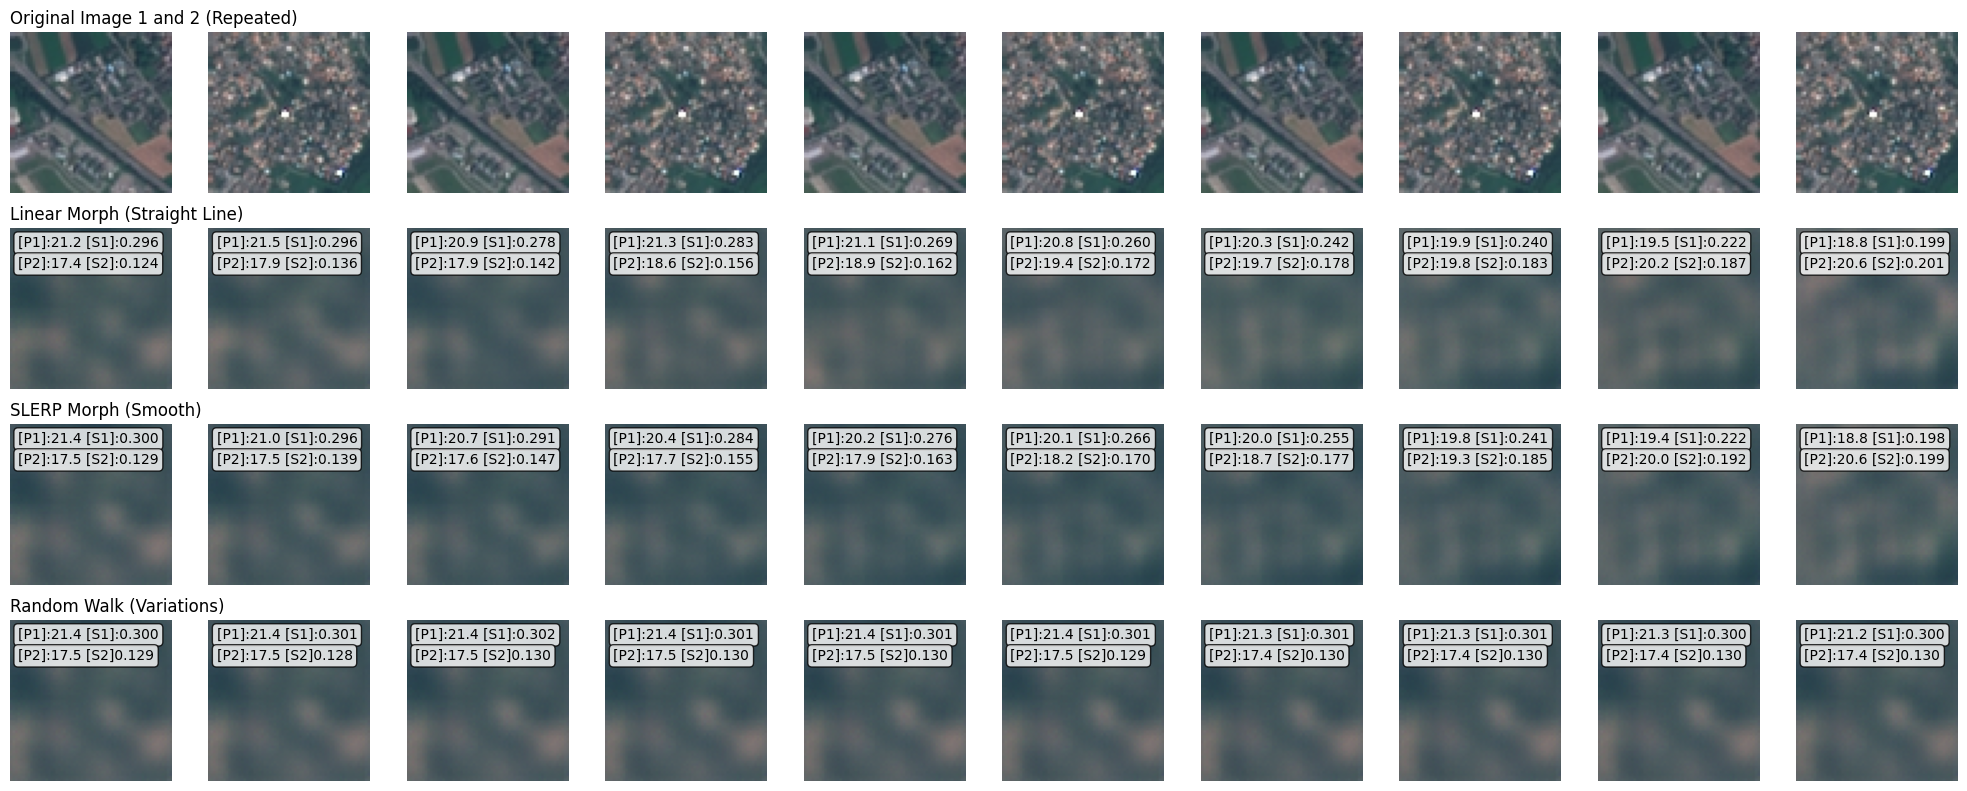

In [ ]:
 # Configuration
LATENT_DIM = 64
EUROSAT_INPUT_SHAPE = (3, 64, 64)

# Check & Run on GPU
DEVICE = detect_device()
print(f"Using device: {DEVICE}")

train_loader, test_loader = load_eurosat(shuffle_test=True)
conv_vae = ConvVAE(latent_dim=LATENT_DIM, input_shape=EUROSAT_INPUT_SHAPE).to(DEVICE)
# ConvVAE
try:
  # Try loading UpsampleVAE weights
  conv_vae.load_state_dict(torch.load('./models/ConvVAEx64.pt', map_location=DEVICE))
  print("Loaded ConvVAEx64.pt")
except FileNotFoundError:
  print("ConvVAEx64.pt not found!")

viz_interpolation(conv_vae, test_loader, "ConvVAEx64")